## Connect to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/

In [ ]:
%cd 'B. Disease Grading' 

In [ ]:
!ls

'1. Original Images'  '2. Groundtruths'   CC-BY-4.0.txt   LICENSE.txt   wandb


## Import packages

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os
import glob
import cv2
import copy
from PIL import Image
import numpy as np
import pandas as pd
import random
from math import ceil
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [ ]:
import os
import time
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Function
from torchsummary import summary
from torch.utils.data import Dataset
import torch.optim as optim
from torchvision import transforms
from torch.optim import lr_scheduler
from PIL import Image, ImageFile
from tqdm.notebook import tqdm as tqdm

device = torch.device("cuda:0")

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed = 1999
seed_everything(seed)

## Analysis Data

In [ ]:
train_image_dir = '1. Original Images/a. Training Set'
train_image_path = os.path.join(os.getcwd(),train_image_dir)

train_out_dir = '2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv'
train_out_path = os.path.join(os.getcwd(),train_out_dir)

test_image_dir = '1. Original Images/b. Testing Set'
test_image_path = os.path.join(os.getcwd(),test_image_dir)

test_out_dir = '2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv'
test_out_path = os.path.join(os.getcwd(),test_out_dir)

In [ ]:
train_df = pd.read_csv(train_out_dir)
test_df = pd.read_csv(test_out_dir)

In [ ]:
print(f'There are {len(train_df)} images in train dataset')
print(f'There are {len(test_df)} images in test dataset')

There are 413 images in train dataset
There are 103 images in test dataset


In [ ]:
columns = ['Image name', 'Retinopathy grade', 'Risk of macular edema ']
train_df = train_df.reindex(columns = columns)

In [ ]:
train_df.head()

Image name  Retinopathy grade  Risk of macular edema 
0  IDRiD_001                  3                       2
1  IDRiD_002                  3                       2
2  IDRiD_003                  2                       2
3  IDRiD_004                  3                       2
4  IDRiD_005                  4                       0

In [ ]:
train_df.describe()

Retinopathy grade  Risk of macular edema 
count         413.000000              413.000000
mean            1.719128                1.043584
std             1.387723                0.949215
min             0.000000                0.000000
25%             0.000000                0.000000
50%             2.000000                1.000000
75%             3.000000                2.000000
max             4.000000                2.000000

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Image name              413 non-null    object
 1   Retinopathy grade       413 non-null    int64 
 2   Risk of macular edema   413 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.8+ KB


In [ ]:
test_df.describe()

Retinopathy grade  Risk of macular edema 
count         103.000000              103.000000
mean            1.728155                1.029126
std             1.415559                0.954415
min             0.000000                0.000000
25%             0.000000                0.000000
50%             2.000000                1.000000
75%             3.000000                2.000000
max             4.000000                2.000000

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Image name              103 non-null    object
 1   Retinopathy grade       103 non-null    int64 
 2   Risk of macular edema   103 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


### Check if all image has the same shape



In [ ]:
# img_size = []
# for img_path in glob.glob(train_image_path + '/*.jpg') + glob.glob(test_image_path + '/*.jpg'):
#   img = cv2.imread(img_path)
#   img_size.append(img.shape)

# img_size = set(img_size)
# print(f'Shape of all image in dataset is {img_size}')

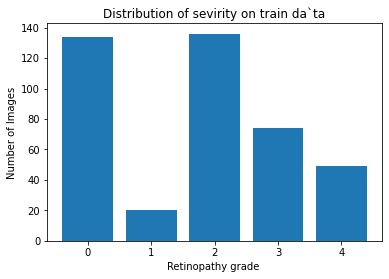

In [ ]:
count = train_df.groupby('Retinopathy grade').nunique()

grade = [0,1,2,3,4]
num_image = count['Image name']
plt.bar(grade,num_image)
plt.xlabel('Retinopathy grade ')
plt.ylabel('Number of Images')
plt.title('Distribution of sevirity on train da`ta')
plt.show()

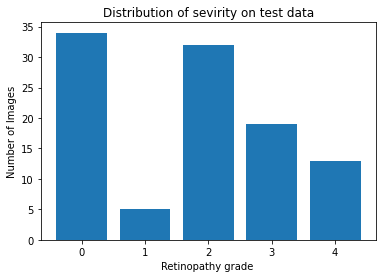

In [ ]:
count = test_df.groupby('Retinopathy grade').nunique()

grade = [0,1,2,3,4]
num_image = count['Image name']
plt.bar(grade,num_image)
plt.xlabel('Retinopathy grade ')
plt.ylabel('Number of Images')
plt.title('Distribution of sevirity on test data')
plt.show()

## Visualize Images

In [ ]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=ceil(len(img_matrix_list) / ncols), ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

In [ ]:
def plot_random_images(main_title, image_folder_path, df, num = 12, transform = None):
    img_dict = {}
    for idx, row, in df.iterrows():
      try:
          image_name, severity, risk = row[0], row[1], row[2]
          if image_name not in img_dict:
              img_dict[image_name] = [severity, risk]
      except Exception as e:
        print(e)

    # randomly choose 12 images to plot
    img_files_list = np.random.choice(list(img_dict.keys()), num)
    print("The images' names are {}".format(img_files_list))
    img_matrix_list = []
    img_title_list = []

    for img_file in img_files_list:
        image_file_path = os.path.join(image_folder_path, img_file + '.jpg')
        if transform:
          img = transform(image_file_path)
        else:
          img = cv2.imread(image_file_path)[:,:,::-1]  
        img_matrix_list.append(img)
        title = f'Name: {img_file}-Severity: {img_dict[img_file][0]}-Risk: {img_dict[img_file][1]}'
        img_title_list.append(title)
    
    return plot_multiple_img(img_matrix_list, title_list = img_title_list, ncols = 4, main_title=main_title)

The images' names are ['IDRiD_145' 'IDRiD_155' 'IDRiD_206' 'IDRiD_267' 'IDRiD_120' 'IDRiD_048'
 'IDRiD_397' 'IDRiD_053' 'IDRiD_186' 'IDRiD_190' 'IDRiD_039' 'IDRiD_255']


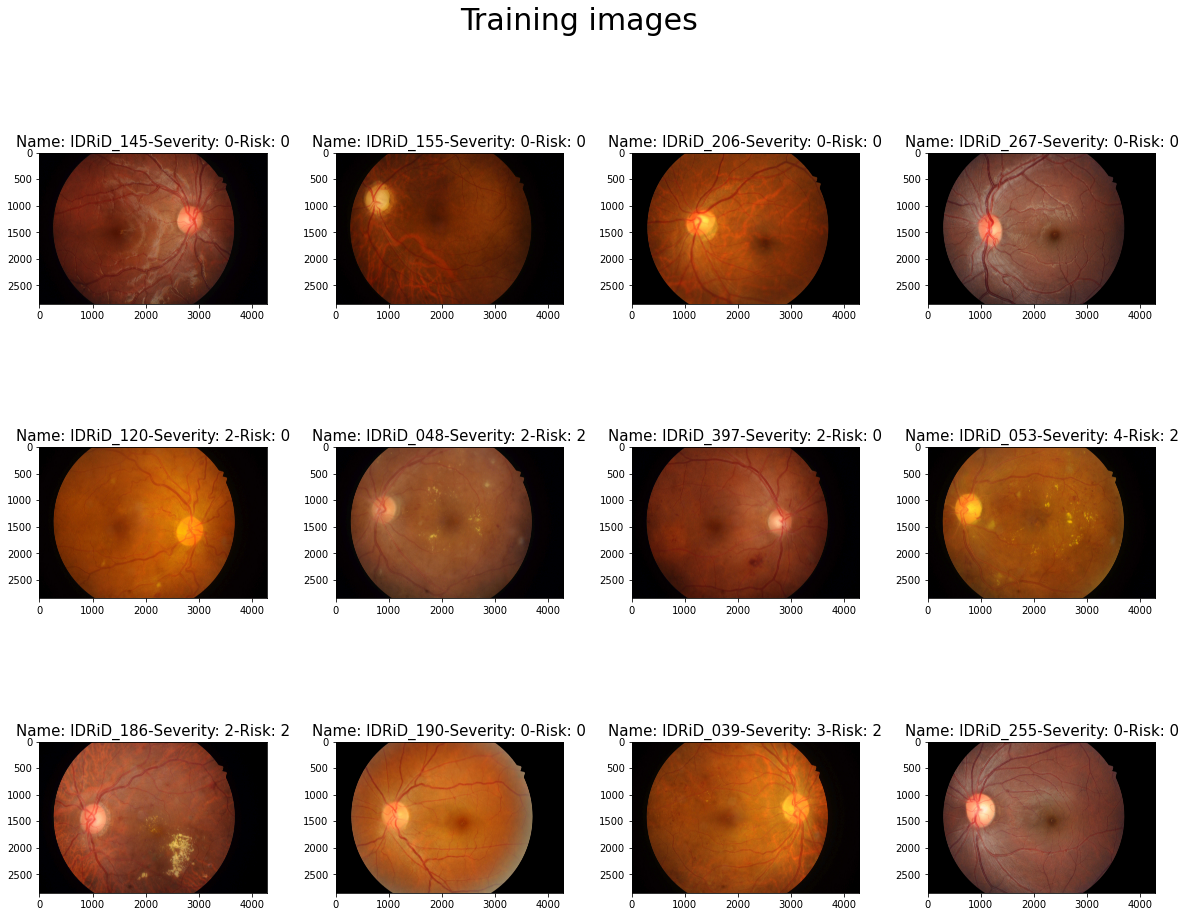

In [ ]:
%%time
plot_random_images("Training images", train_image_path, train_df)

In [ ]:
def plot_image_per_class(image_folder_path, df, num_per_class, type):
  classes = tuple(np.unique(df[type].values))

  img_matrix_list = []
  img_title_list = []

  def read_img(img_name):
    img_path = os.path.join(image_folder_path, img_name + '.jpg')
    img = cv2.imread(img_path)[:,:,::-1]  

    return img
  
  for c in classes:
    images = tuple(df[df[type] == c]['Image name'].values)
    choose_imgs = list(np.random.choice(images, num_per_class))
    img_path_lsts = list(map(lambda x: read_img(x), choose_imgs))
    img_matrix_list += img_path_lsts

    for img in choose_imgs:
      title = f'Name: {img}-Level: {c}'
      img_title_list.append(title)

  return plot_multiple_img(img_matrix_list=img_matrix_list, title_list=img_title_list, ncols=num_per_class, main_title=type)

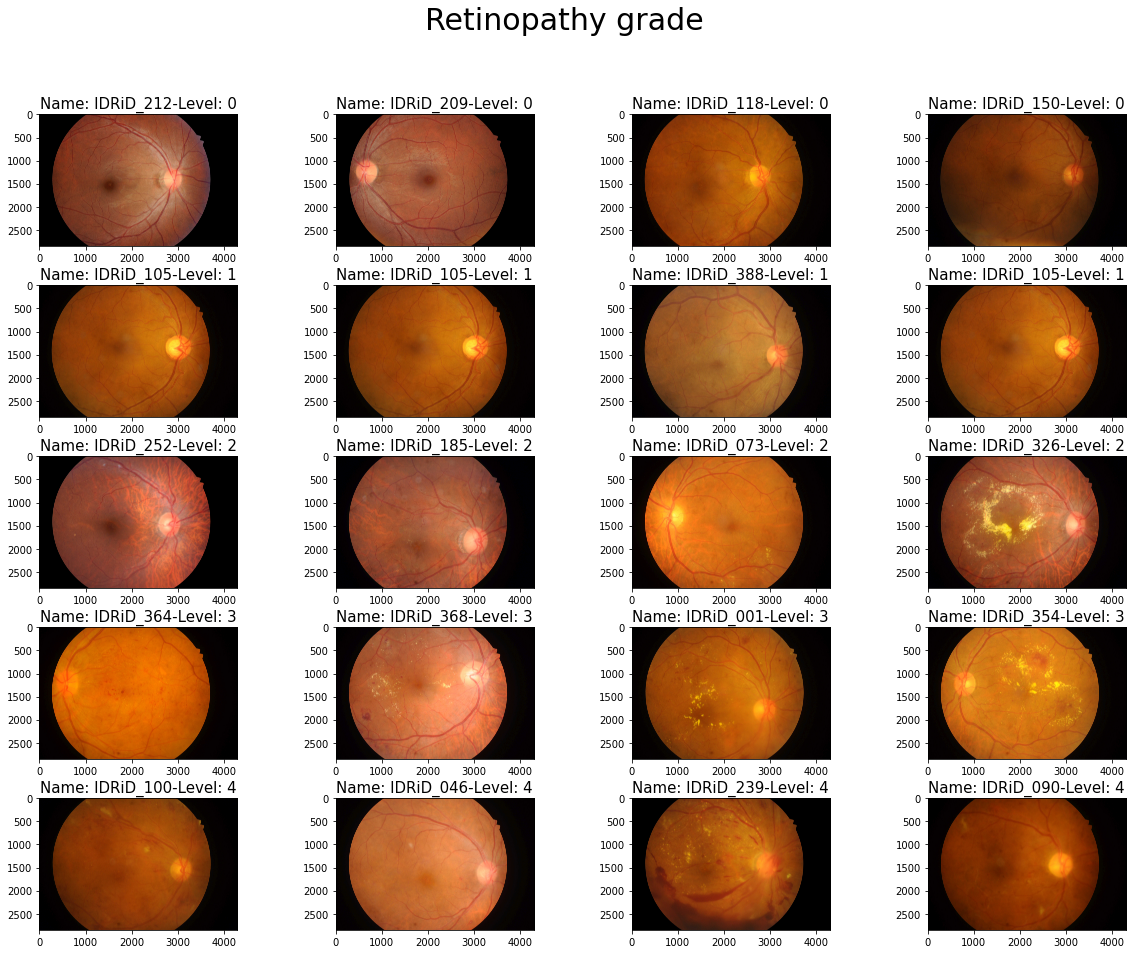

CPU times: user 24.3 s, sys: 75 ms, total: 24.4 s
Wall time: 30.3 s


In [ ]:
%%time
plot_image_per_class(train_image_path, train_df, 4, 'Retinopathy grade')

### Define image processing method

In [ ]:
## Code references: https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
# Code references: https://www.kaggle.com/taindow/pre-processing-train-and-test-images

def circle_crop(img, sigmaX=30):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def load_ben_color(path, img_size = 512, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (img_size, img_size))
    image=cv2.addWeighted( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

The images' names are ['IDRiD_018' 'IDRiD_242' 'IDRiD_332' 'IDRiD_330' 'IDRiD_069' 'IDRiD_249'
 'IDRiD_328' 'IDRiD_339' 'IDRiD_361' 'IDRiD_106' 'IDRiD_028' 'IDRiD_052']


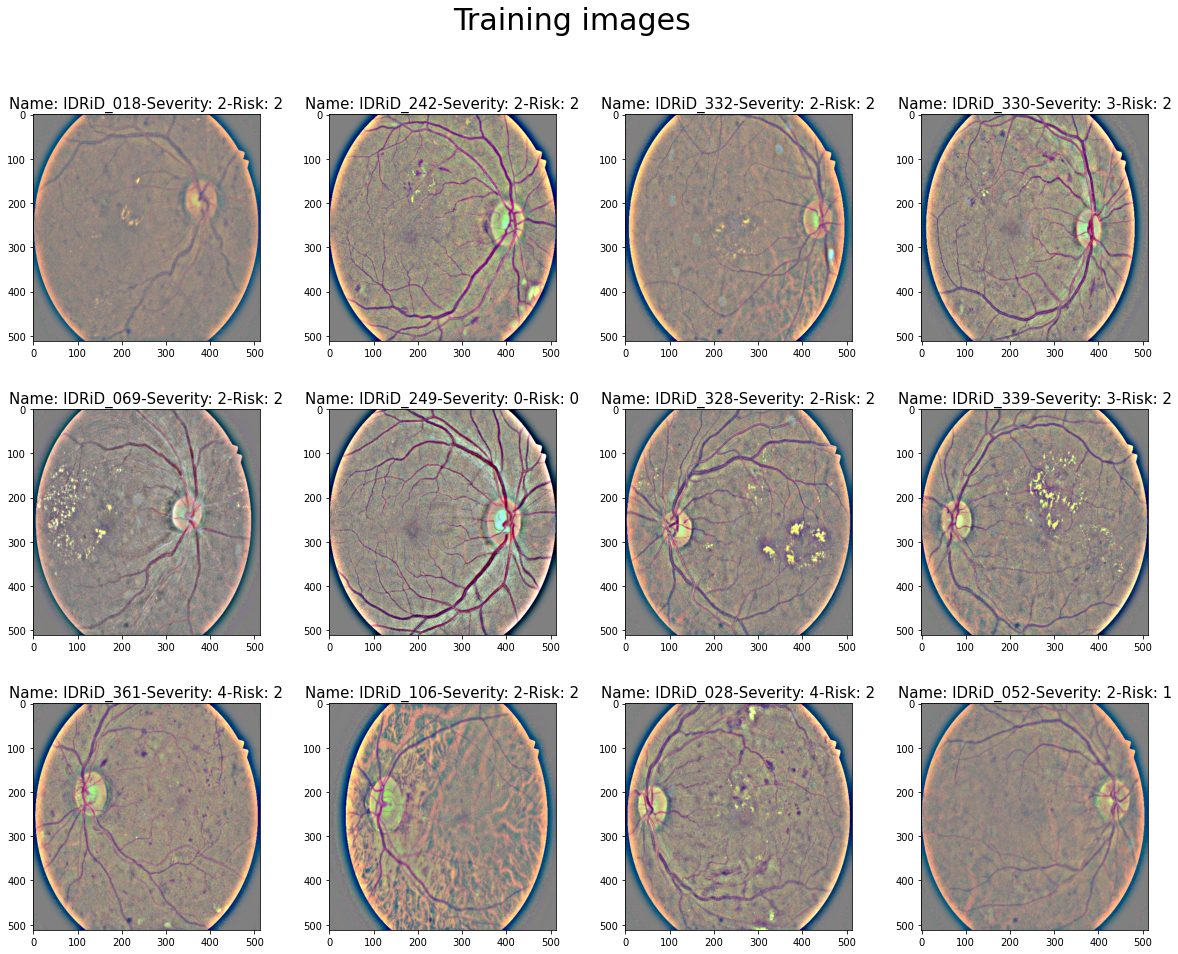

CPU times: user 7.7 s, sys: 62.1 ms, total: 7.76 s
Wall time: 7.27 s


In [ ]:
%%time
plot_random_images("Training images", train_image_path, train_df, transform=load_ben_color)

The images' names are ['IDRiD_403' 'IDRiD_111' 'IDRiD_208' 'IDRiD_139' 'IDRiD_247' 'IDRiD_035'
 'IDRiD_127' 'IDRiD_137' 'IDRiD_050' 'IDRiD_211' 'IDRiD_379' 'IDRiD_296']


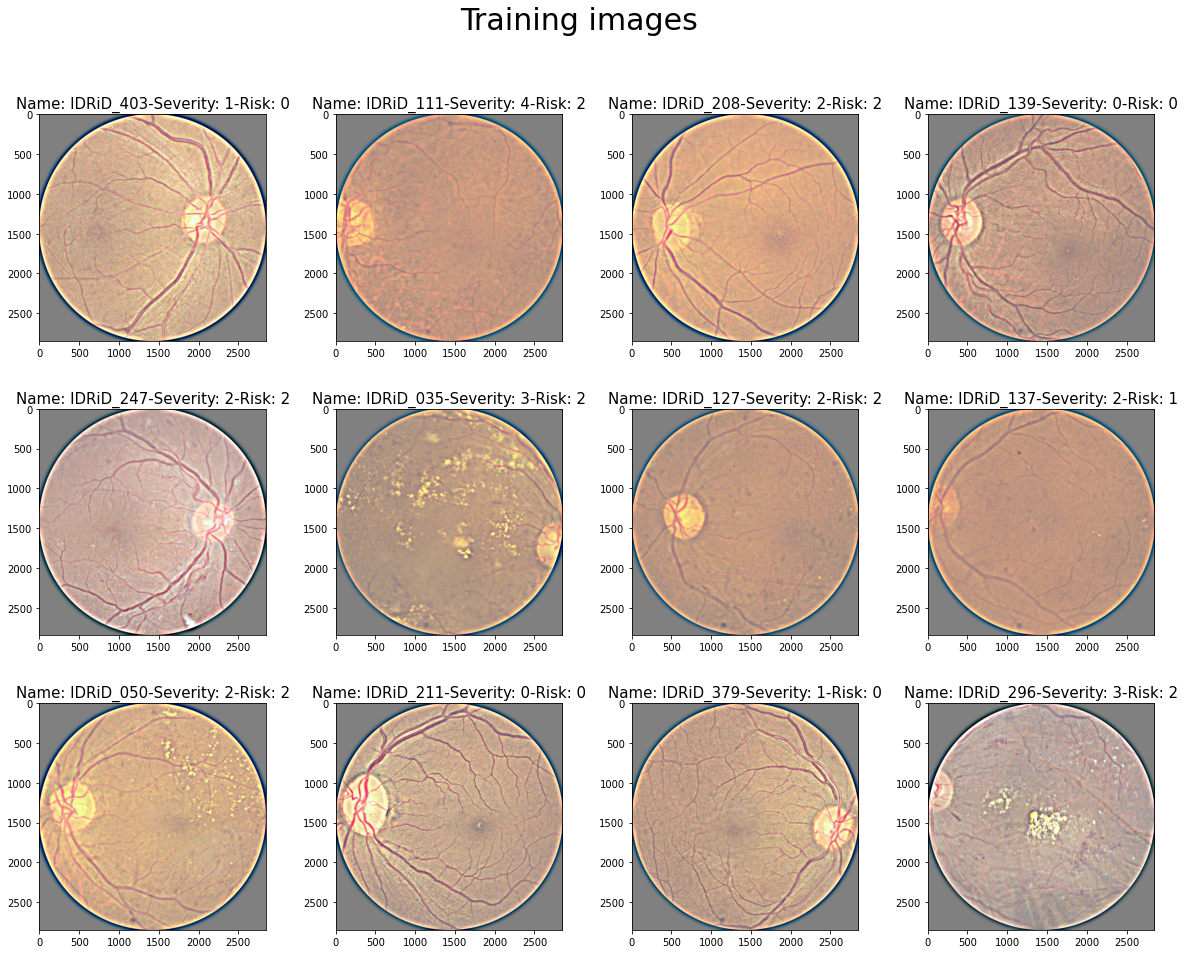

CPU times: user 1min 28s, sys: 118 ms, total: 1min 28s
Wall time: 53.8 s


In [ ]:
%%time
plot_random_images("Training images", train_image_path, train_df, transform=circle_crop)

### Compare image before and after processing

512 512


Text(0.5, 1.0, 'Before')

Text(0.5, 1.0, 'After')

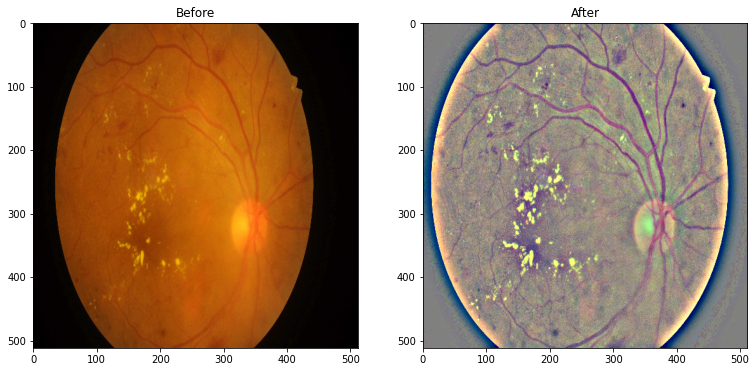

In [ ]:
dpi = 80 #inch

path= os.path.join(train_image_path, str(train_df['Image name'][0]) + '.jpg')

origin_image = cv2.imread(path)
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)
origin_image = cv2.resize(origin_image, (512, 512))

image = load_ben_color(path,sigmaX=10)

height, width = 512, 512
print(height, width)

SCALE=0.5
figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

fig, ax = plt.subplots(1, 2, figsize  = figsize)
ax[0].imshow(origin_image)
ax[0].set_title('Before')
ax[1].imshow(image, cmap='gray')
ax[1].set_title('After')

plt.show()

## Augmentations

<img src='https://albumentations.ai/docs/images/getting_started/augmenting_images/augmentation_pipeline_visualized.jpg'>

### Visualize some augmentation techniques

In [ ]:
from torchvision import transforms

In [ ]:
def visualize_augmentations(image_path, idx=0, samples=10, cols=5):
    img = cv2.imread(image_path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = transforms.ToPILImage()(image)

    transform = transforms.Compose([
                                   transforms.RandomHorizontalFlip(p=0.6),
                                   transforms.RandomRotation((-120, 120)),
    ])

    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image = transform(image)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

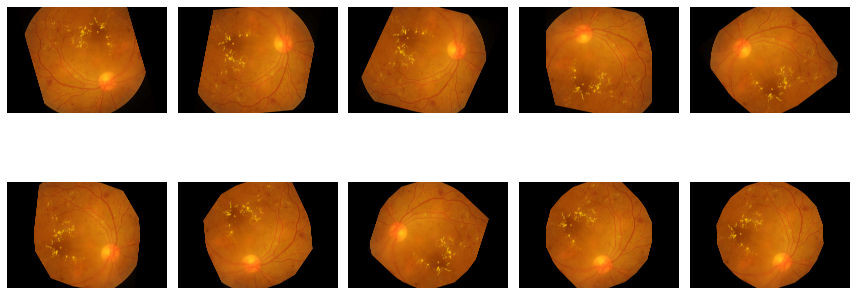

In [ ]:
visualize_augmentations(os.path.join(train_image_path, str(train_df['Image name'][0]) + '.jpg'))

## Modeling

### Define Dataset

In [ ]:
class RetinopathyDatasetTrain(Dataset):

    def __init__(self, csv_file, img_path, transforms = None):
        self.data = pd.read_csv(csv_file)
        self.img_path = img_path
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data['Image name'][idx]
        image_path = os.path.join(self.img_path, img_name + '.jpg')

        image = load_ben_color(image_path, img_size=512)
        image = transforms.ToPILImage()(image)

        if self.transforms:
          image = self.transforms(image)
        
        label = torch.tensor(self.data.loc[idx, 'Retinopathy grade'])

        return image, label

### Define model

In [ ]:
model = torchvision.models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)

model = model.to(device)

In [ ]:
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           9,408
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
         MaxPool2d-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]           4,096
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,864
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]          16,384
      BatchNorm2d-12        [-1, 256, 128, 128]             512
           Conv2d-13        [-1, 256, 128, 128]          16,384
      BatchNorm2d-14        [-1, 256, 1

###Install timm package to use efficient net pretrained model

In [ ]:
!pip install timm

     |████████████████████████████████| 245kB 13.8MB/s 


In [ ]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_lite0',
 'ens_adv_inception_resnet_v2',
 'ese_vovnet19b_dw',
 'ese_vovnet39b',
 'fbnetc_100',
 'gluon_inception_v3',
 'gluon_resnet18_v1b',
 'gluon_resnet34_v1b',
 'gluon_resnet50_v1b',
 'gluon_resnet50_v1c',
 'gluon_resnet50_v1d',
 'gluon_resnet50_v1s',
 'gluon_resn

### Define efficientnet pretrained model

In [ ]:
model = timm.create_model('efficientnet_b1', pretrained=True)

for param in model.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, 5)

model = model.to(device)

### Define transform for data augmentations

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-60, 60)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])           
])

trainset     = RetinopathyDatasetTrain(train_out_path, train_image_path, transforms =train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
valset       = RetinopathyDatasetTrain(test_out_path, test_image_path, transforms =val_transform)
val_loader   = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
dataloaders = {'train' : train_loader, 'val' : val_loader}
dataset_sizes = {'train' : len(trainset) , 'val' : len(valset)}

### Define Logging class to log training and validation information

In [ ]:
class Logging:
  def __init__(self):
        # history of loss values in each epoch
        self.loss_history={
            "train": [],
            "val": [],
        }

        # histroy of metric values in each epoch
        self.metrics_history={
            "train": [],
            "val": [],
        }
  
  def log(self, loss, acc, training):
        if training:
            train_val = "train"
        else:
            train_val = "val"

        self.loss_history[train_val].append(loss)
        self.metrics_history[train_val].append(acc)

### Define training method

In [ ]:
def train_model(model, log, optimizer, scheduler, criterion, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])), desc = 'Progress')
            counter = 0
            # Iterate over data.
            for inputs, labels in tk0:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                counter += 1
                tk0.set_postfix(loss=(running_loss / (counter * dataloaders[phase].batch_size)), acc = (running_corrects / (counter * dataloaders[phase].batch_size)) )

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            log.log(epoch_loss, epoch_acc, phase == 'train')

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Traning

In [ ]:
## Train resnet50 model
log = Logging()
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10)
criterion = nn.CrossEntropyLoss()
resnet50 = train_model(model, log, optimizer, scheduler, criterion)

Epoch 0/14
----------



train Loss: 1.5904 Acc: 0.2857



val Loss: 1.5193 Acc: 0.3107

Epoch 1/14
----------



train Loss: 1.3773 Acc: 0.4358



val Loss: 1.3195 Acc: 0.4660

Epoch 2/14
----------



train Loss: 1.2537 Acc: 0.5182



val Loss: 1.3090 Acc: 0.4757

Epoch 3/14
----------



train Loss: 1.1611 Acc: 0.5012



val Loss: 1.3392 Acc: 0.3592

Epoch 4/14
----------



train Loss: 1.1562 Acc: 0.5036



val Loss: 1.3317 Acc: 0.3786

Epoch 5/14
----------



train Loss: 1.1769 Acc: 0.5109



val Loss: 1.2959 Acc: 0.4854

Epoch 6/14
----------



train Loss: 1.0869 Acc: 0.5424



val Loss: 1.2295 Acc: 0.4854

Epoch 7/14
----------



train Loss: 1.0611 Acc: 0.5738



val Loss: 1.2710 Acc: 0.3786

Epoch 8/14
----------



train Loss: 1.0504 Acc: 0.5303



val Loss: 1.3022 Acc: 0.4951

Epoch 9/14
----------



train Loss: 1.0697 Acc: 0.5375



val Loss: 1.2208 Acc: 0.4951

Epoch 10/14
----------



train Loss: 0.9927 Acc: 0.6029



val Loss: 1.1981 Acc: 0.4951

Epoch 11/14
----------



train Loss: 0.9863 Acc: 0.5738



val Loss: 1.1703 Acc: 0.4854

Epoch 12/14
----------



train Loss: 0.9729 Acc: 0.5860



val Loss: 1.1779 Acc: 0.4951

Epoch 13/14
----------



train Loss: 1.0127 Acc: 0.6005



val Loss: 1.1667 Acc: 0.5146

Epoch 14/14
----------



train Loss: 0.9817 Acc: 0.6102



val Loss: 1.1774 Acc: 0.4951

Training complete in 42m 27s
Best val Acc: 0.514563


In [ ]:
# Save best model to disk
torch.save(resnet50.state_dict(), os.path.join(os.getcwd(), 'resnet50.pt'))

In [ ]:
loss_hist, metrics_history = log.loss_history, log.metrics_history
train_hist = torch.stack(metrics_history["train"])
val_hist = torch.stack(metrics_history["val"])

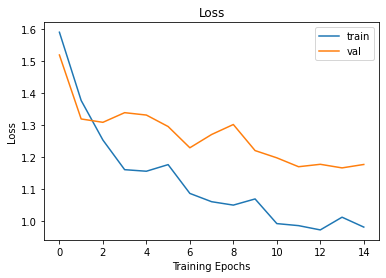

In [ ]:
# Train-Validation Progress
# plot loss progress

plt.title("Loss")
plt.plot(range(14+1),loss_hist["train"],label="train")
plt.plot(range(14+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

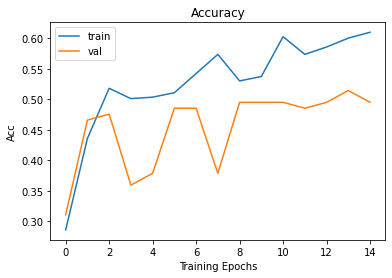

In [ ]:
# Train-Validation Progress

# plot loss progress
plt.title("Accuracy")
plt.plot(range(14+1),train_hist.cpu(),label="train")
plt.plot(range(14+1),val_hist.cpu(),label="val")
plt.ylabel("Acc")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [ ]:
#Train efficientnet model
log = Logging()
optimizer = optim.Adam(model.parameters(),lr = 0.001, weight_decay=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10)
criterion = nn.CrossEntropyLoss()
efficientnetb1 = train_model(model, log, optimizer, scheduler, criterion)

Epoch 0/14
----------



train Loss: 1.4286 Acc: 0.4455



val Loss: 1.3720 Acc: 0.3689

Epoch 1/14
----------



train Loss: 1.2632 Acc: 0.5036



val Loss: 1.3095 Acc: 0.4272

Epoch 2/14
----------



train Loss: 1.1751 Acc: 0.5157



val Loss: 1.2883 Acc: 0.4563

Epoch 3/14
----------



train Loss: 1.1334 Acc: 0.5521



val Loss: 1.2602 Acc: 0.4757

Epoch 4/14
----------



train Loss: 1.0819 Acc: 0.5884



val Loss: 1.2421 Acc: 0.4563

Epoch 5/14
----------



train Loss: 1.0406 Acc: 0.5884



val Loss: 1.2297 Acc: 0.4563

Epoch 6/14
----------



train Loss: 1.0337 Acc: 0.5908



val Loss: 1.2327 Acc: 0.4757

Epoch 7/14
----------



train Loss: 0.9986 Acc: 0.6077



val Loss: 1.2366 Acc: 0.4660

Epoch 8/14
----------



train Loss: 0.9788 Acc: 0.6029



val Loss: 1.2038 Acc: 0.4563

Epoch 9/14
----------



train Loss: 0.9676 Acc: 0.6416



val Loss: 1.2207 Acc: 0.4272

Epoch 10/14
----------



train Loss: 0.9735 Acc: 0.6102



val Loss: 1.2152 Acc: 0.4369

Epoch 11/14
----------



train Loss: 0.9473 Acc: 0.6102



val Loss: 1.2099 Acc: 0.4272

Epoch 12/14
----------



train Loss: 0.9094 Acc: 0.6513



val Loss: 1.2104 Acc: 0.4369

Epoch 13/14
----------



train Loss: 0.9307 Acc: 0.6174



val Loss: 1.2098 Acc: 0.4466

Epoch 14/14
----------



train Loss: 0.9429 Acc: 0.6150



val Loss: 1.2083 Acc: 0.4369

Training complete in 41m 23s
Best val Acc: 0.475728


In [ ]:
torch.save(efficientnetb1.state_dict(), os.path.join(os.getcwd(), 'efficientnetb1.pt'))

In [ ]:
loss_hist, metrics_history = log.loss_history, log.metrics_history
train_hist = torch.stack(metrics_history["train"])
val_hist = torch.stack(metrics_history["val"])

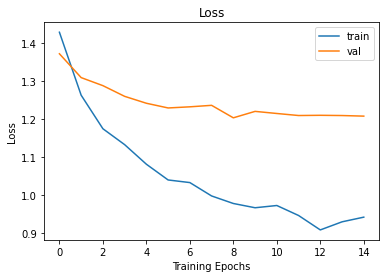

In [ ]:
# Train-Validation Progress

# plot loss progress
plt.title("Loss")
plt.plot(range(15),loss_hist["train"],label="train")
plt.plot(range(15),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

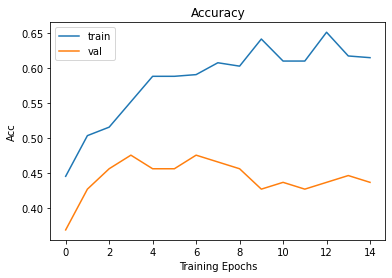

In [ ]:
# Train-Validation Progress

# plot loss progress
plt.title("Accuracy")
plt.plot(range(15),train_hist.cpu(),label="train")
plt.plot(range(15),val_hist.cpu(),label="val")
plt.ylabel("Acc")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

## Grad-CAM Visualization 
Code reference: https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/gradcam.py

In [ ]:
class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x

In [ ]:
class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x

In [ ]:
def preprocess_image(img_path):
    img = load_ben_color(img_path)
    img = val_transform(img)
    img.unsqueeze_(0)
    input = img.requires_grad_(True)
    return input


In [ ]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))

In [ ]:
class GradCam:
    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [ ]:
#Using resnet50 model to extract feature map to visualize heatmap because resnet50 has better result
#Result image is saved into disk with name cam.jpg

model = resnet50

grad_cam = GradCam(model=model, feature_module=model.layer4, target_layer_names=["2"], use_cuda=True)

path= os.path.join(train_image_path, str(train_df['Image name'][0]) + '.jpg')
img = cv2.imread(path, 1)
img = np.float32(cv2.resize(img, (512, 512))) / 255

input = preprocess_image(path)

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
target_index = None
mask = grad_cam(input, target_index)

print(mask)

show_cam_on_image(img, mask)